# stat qualification des données

In [1]:
import os
from dotenv import load_dotenv
from intake import open_catalog
import pandas as pd
import numpy as np
import geopandas as gpd
from datetime import datetime, timedelta
from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import warnings
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sqlalchemy import create_engine, text
import networkx as nx

load_dotenv()

True

In [9]:
catalog_path = f'{os.getenv("PROJECT_PATH")}//data_reference_feux.yaml'
table_viirs_snpp="incendies_VIIRS_SNPP"
table_viirs_noaa="incendies_VIIRS_NOAA20"
table_brute="sentinel_surfaces_detectees"

regroupement_type=np.median
input='A:/INDICATEUR_FEUX/2023/'

In [3]:
#cc=pd.read_csv('list_2023_cc.csv',delimiter=';',header=0)

In [4]:
def reg_lineaire(data, index,time,fichier):
    plt.clf()

    if len(data[:index]) > 4:  
        X = np.arange(len(data)).reshape(-1, 1)
        y = data
        
        model = LinearRegression()
        model.fit(X, y)
        trend = model.predict(X)
        slope = model.coef_[0]
        
        if slope >= 0:
            breakpoints = 0
            delta_delay=0
            rbr=0
            start_of_trend=np.nan

        else:

            df = pd.DataFrame({'time':time})
            df['time'] = pd.to_datetime(df['time'].apply(lambda x: x.strftime('%Y-%m-%d')), errors='coerce')
            df['nbr']=data
            df.set_index('time', inplace=True)
            
            percentage = 0.05  
            window_size = max(3, int(len(df) * percentage)) 

            if not df.index.is_unique:
                df = df[~df.index.duplicated(keep='first')]

            df['slope'] = np.nan  

            idx = np.arange(len(df))
            for i in range(len(df) - window_size + 1):
                y = df['nbr'].iloc[i:i+window_size].values.reshape(-1, 1)
                X = idx[i:i+window_size].reshape(-1, 1)

                model = LinearRegression().fit(X, y)
                df['slope'].iloc[i + window_size - 1] = model.coef_[0]

            trends = []
            start_of_trend = None
            prev_i = None  

            for i in df.index:
                if df.loc[i, 'slope'] < 0:
                    if start_of_trend is None:
                        start_of_trend = prev_i
                        if start_of_trend is None:
                            start_of_trend = i
                    end_of_trend = i
                elif start_of_trend is not None and df.loc[i, 'slope'] >= 0:
                    # Calculer la différence de la valeur de 'nbr' entre le début et la fin de la tendance
                    difference = abs(df.loc[start_of_trend, 'nbr'] - df.loc[end_of_trend, 'nbr'])
                    # Calcul du nombre de jours depuis le début du DataFrame jusqu'au début de la tendance
                    if (end_of_trend - start_of_trend).days <= 200:
                        trends.append((start_of_trend, end_of_trend, difference))
                    start_of_trend = None

                prev_i = i  # Mise à jour de l'index précédent

            if start_of_trend is not None and (df.index[-1] - start_of_trend).days <= 200:
                difference = abs(df.loc[start_of_trend, 'nbr'] - df.loc[df.index[-1], 'nbr'])
                trends.append((start_of_trend, df.index[-1], difference))

            if trends is not None:
                # Trouver la tendance avec la plus grande différence de valeur
                longest_trend = max(trends, key=lambda x: x[2])
                delta_delay = (time[index]-longest_trend[0]).days
                #print(delta_delay)
                print("La tendance baissière la plus impactante commence à :", longest_trend[0],
                    ", se termine à :", longest_trend[1], "avec une différence de :", longest_trend[2], "et a commencé", delta_delay, "jours après le début des données.")
                
                breakpoints = (df.loc[longest_trend[0], 'nbr']) - (data[index])
                ratio=breakpoints/np.sqrt(abs(df.loc[longest_trend[0], 'nbr']/1000))
                rbr=breakpoints/(df.loc[longest_trend[0], 'nbr']+0.001)

                #plt.figure()
                #df['nbr'].plot()
                #plt.axvline(x=longest_trend[1],color='g',ls='--',label='fin tendance baissière')
                #plt.axvline(x=longest_trend[0],color='r',ls='--',label='start rupture')
                #plt.axvline(x=(time[index]).strftime('%Y-%m-%d'),color='k',ls='--',label='date of detection')
                #plt.savefig(rep+'figure/'+fichier[:-3]+'.png')
            
            else:
                print("Aucune tendance baissière significative détectée.")
                breakpoints=np.nan
                delta_delay=np.nan
                rbr=np.nan
                start_of_trend=np.nan
    else:
        breakpoints = np.nan
        delta_delay=np.nan
        rbr=np.nan
        start_of_trend=np.nan

    return breakpoints, delta_delay, rbr,start_of_trend

In [5]:
def qualif_table(list_surfae_id_h3,value):
    conex = create_engine(f'postgresql://{os.getenv("DB_USER")}:{os.getenv("DB_PWD")}@{os.getenv("DB_HOST")}:{os.getenv("DB_PORT")}/{os.getenv("DB_WORKSPACE")}')

    sql_query = f"""
    UPDATE feux_cq.{table_brute}
    SET qualification = '{value}'
    WHERE surface_id_h3 = :surface_id
    """

    sql = text(sql_query)
    for i in range (len(list_surfae_id_h3)):
        with conex.begin() as conn:
            conn.execute(sql, {'surface_id': list_surfae_id_h3[i]})
    
    return

In [6]:
def function_regrouement(rep):
    data = []
    for fichier in os.listdir(rep):
        if fichier.endswith('.nc'):
            chemin_complet = os.path.join(rep, fichier)
            fichier_data = {'filename': os.path.basename(fichier), 'surface_id_h3': fichier[:-14]}

            date_cible = fichier[36:-3]
            with Dataset(chemin_complet, 'r') as nc:   
                print(fichier)             
                try:
                    if 'time' in nc.variables:
                        time_var = nc.variables['time']
                        times = num2date(time_var[:], units=time_var.units)

                        index = None
                        for i, time in enumerate(times):
                            if str(time).startswith(date_cible):
                                index = i
                                break
                        
                        if index is not None:
                            #print(f"Date trouvée à l'index {index}: {times[index]}")
                            indicateur = ['nbr','ndvi','bais2','ndwi','badi','nbr+']  
                            for var_name in indicateur:
                                if var_name in nc.variables:
                                    var_data = nc.variables[var_name][index, :, :]  
                                    mask = np.array(nc.variables['mask'][:], dtype=float)
                                    mask[mask == 0] = np.nan

                                    masked_var = np.array(var_data) * mask

                                    filtered_var = masked_var[~np.isnan(masked_var)]
                                    filtered_var = regroupement_type(filtered_var)
                                    fichier_data[var_name] = filtered_var
                            median_values = []
                            new_times = []
                            indicateur = ['nbr']  
                            for var_name in indicateur:
                                if var_name in nc.variables:
                                    var_data = nc.variables[var_name][:, :, :]  
                                    mask = np.array(nc.variables['mask'][:], dtype=float)
                                    mask[mask == 0] = np.nan
                                    
                                    median_values = []
                                    
                                    for i in range(var_data.shape[0]):  
                                        masked_slice = var_data[i, :, :] * mask
                                        masked_values = masked_slice[~np.isnan(masked_slice)]
                                        if masked_values.size > 0:
                                            median_value = regroupement_type(masked_values)
                                            median_values.append(median_value)
                                            new_times.append(times[i])

                                    index = None
                                    for i, time in enumerate(new_times):
                                        if str(time).startswith(date_cible):
                                            index = i
                                            break

                                    median_values = np.array(median_values)

                                    break_point,delay, rbr,date_trend = reg_lineaire(median_values,index,new_times,fichier)
                                    fichier_data['d'+var_name] = break_point
                                    fichier_data['std'+var_name]=np.std(median_values)
                                    fichier_data['day_'+var_name] = delay
                                    fichier_data['rupture_'+var_name] = date_trend
                                    fichier_data['RBR'] = rbr

                            data.append(fichier_data)
                                
                except OverflowError:
                    print(f"Erreur sur le fichier {fichier}")

    return data

In [7]:
data=function_regrouement(input)
df = pd.DataFrame(data)

L2A_T58KDB_20231227_8f9f5e5419360c1_2023-12-27.nc
La tendance baissière la plus impactante commence à : 2023-10-03 00:00:00 , se termine à : 2023-12-29 00:00:00 avec une différence de : 0.6103675975891658 et a commencé 85 jours après le début des données.
L2A_T58KDB_20231227_8f9f5e541923a50_2023-12-27.nc
La tendance baissière la plus impactante commence à : 2023-10-20 00:00:00 , se termine à : 2024-01-03 00:00:00 avec une différence de : 0.5732927904737993 et a commencé 68 jours après le début des données.
L2A_T58KDB_20231227_8f9f5e56a81310e_2023-12-27.nc
La tendance baissière la plus impactante commence à : 2023-10-03 00:00:00 , se termine à : 2023-12-12 00:00:00 avec une différence de : 0.5113135120927558 et a commencé 85 jours après le début des données.
L2A_T58KDB_20231227_8f9f5e545b0041a_2023-12-27.nc
La tendance baissière la plus impactante commence à : 2023-10-30 00:00:00 , se termine à : 2023-12-29 00:00:00 avec une différence de : 0.5147677587627681 et a commencé 58 jours aprè

<Figure size 800x550 with 0 Axes>

In [10]:
def read_viirs_data(table):
    catalog = open_catalog(catalog_path)
    dataCatalog = getattr(catalog, table)
    viirs = dataCatalog.read()
    viirs['BegDate']=pd.to_datetime(viirs['BegDate'])
    viirs=gpd.GeoDataFrame(viirs,geometry='geometry', crs="EPSG:3163")

    return(viirs)

viirs_snpp=read_viirs_data(table_viirs_snpp)
viirs_noaa=read_viirs_data(table_viirs_noaa)

viirs=pd.concat([viirs_noaa,viirs_snpp])

In [11]:
catalog = open_catalog(catalog_path)
dataCatalog = getattr(catalog, table_brute)
brute = dataCatalog.read()

complete=pd.merge(df,brute,how='left',on='surface_id_h3')
complete = complete.drop(columns=['filename','nom','province','commune','surface'])

complete=gpd.GeoDataFrame(complete,geometry='geometry', crs="EPSG:3163")
complete['surface']=complete.area/10000

In [12]:
#complete=pd.merge(df,cc,how='left',on='surface_id_h3')
#complete['cloud_coverage'] = pd.to_numeric(complete['cloud_coverage'], errors='coerce')
#complete=complete[complete['cloud_coverage']== 0.0]
#complete = complete.drop(columns=['filename','nom_y','province_y','commune_y','date__x','surface_y','Unnamed: 8','Unnamed: 0','nom_x','province_x','commune_x','surface_x'])


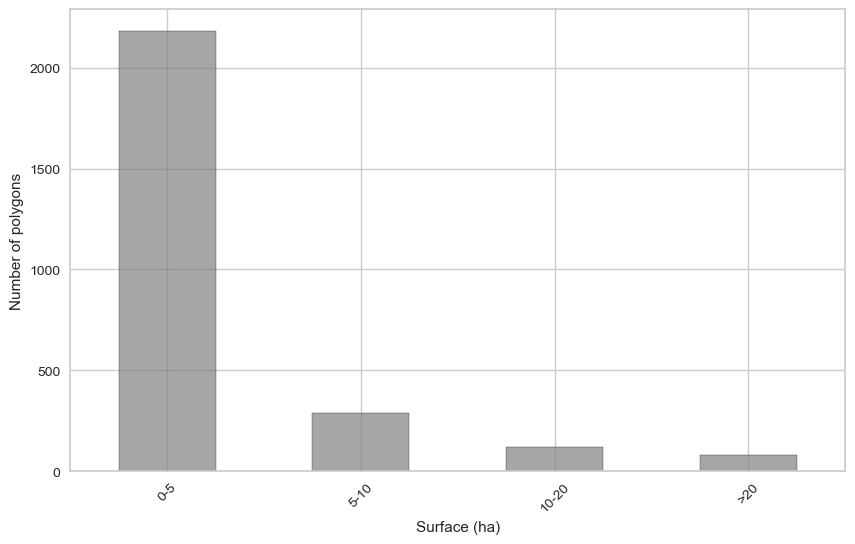

In [13]:
bins = [0, 5, 10, 20, float('inf')]
labels = ['0-5', '5-10', '10-20', '>20']

complete['surface_binned'] = pd.cut(complete['surface'], bins=bins, labels=labels, right=False)

surface_counts = complete['surface_binned'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
surface_counts.plot(kind='bar', edgecolor='black', alpha=0.7,color='grey')
plt.xlabel('Surface (ha)')
plt.ylabel('Number of polygons')
plt.xticks(rotation=45)
plt.show()

In [14]:
intersections = gpd.sjoin(complete, viirs, how='inner', op='intersects')
intersections['rupture_nbr'] = pd.to_datetime(intersections['rupture_nbr'])
intersections['BegDate'] = pd.to_datetime(intersections['BegDate'])
intersections['date_diff'] = ( intersections['BegDate']-intersections['rupture_nbr']).dt.days

intersections=intersections.reset_index(drop=True)
intersections=intersections[(intersections['date_diff'] >= -10) & (intersections['BegDate']< intersections['date_'])]
intersections=intersections.drop(columns=['GenererSur','IdSurface','OrigineY','EndDate','CentroideX','CentroideY','Hash','Bright4_ma','Bright4_mi',
                                          'Bright4_mo','Bright5_ma','Bright5_mi','FRPMax','FRPMoy','Confidence',
                                          'NbDetect','FRPMin','Confiden00','Bright5_mo','OrigineX',
                                          'stdnbr','badi','nbr+','index_right',
                                          'ndwi','RBR','Confiden01','capteur'])

intersections = intersections.sort_values(by=['surface_id_h3', 'date_diff'])
intersections = intersections.drop_duplicates(subset='surface_id_h3', keep='first')

id = set(intersections['surface_id_h3'].unique())
complete['viirs'] = complete['surface_id_h3'].map(lambda x:1 if x in id else 0)
date_diff_dict = intersections.set_index('surface_id_h3')['date_diff'].to_dict()

complete['days_viirs'] = complete['surface_id_h3'].map(date_diff_dict)

In [15]:
col = ['nbr', 'ndvi']
df_indic = complete[col]
df_indic=df_indic.reset_index(drop=True)
df_indic = df_indic.dropna()
list_poly=df['surface_id_h3']

In [16]:
df_indic = df_indic.dropna()
list_poly=df['surface_id_h3']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


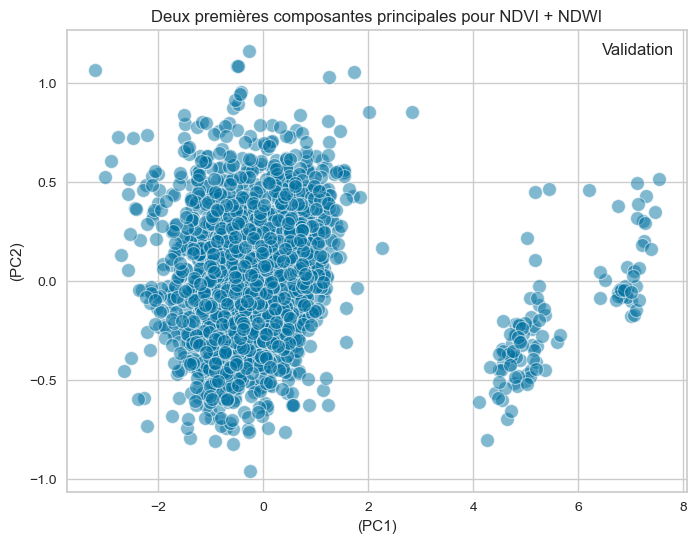

Variance expliquée par chaque composante:
[0.95348613 0.04651387]


In [17]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_indic)

# Application de l'ACP
pca = PCA(n_components=2)  
principal_components = pca.fit_transform(df_scaled)
pca_df = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2'])

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', s=100, alpha=0.5)
plt.title('Deux premières composantes principales pour NDVI + NDWI')
plt.xlabel('(PC1)')
plt.ylabel('(PC2)')
plt.grid(True)
plt.legend(title='Validation')
plt.show()

print("Variance expliquée par chaque composante:")
print(pca.explained_variance_ratio_)

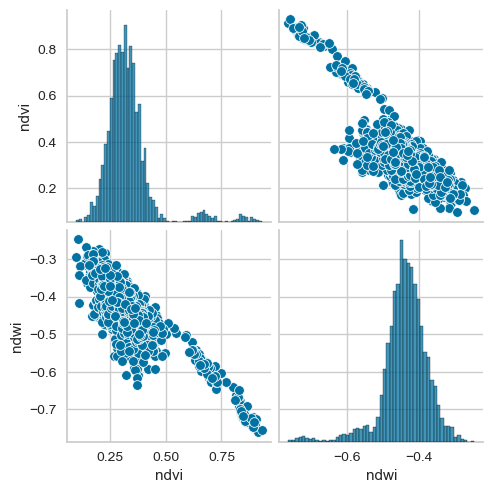

In [18]:
col = [ 'ndvi','ndwi']
df_indic = complete[col]
df_indic=df_indic.reset_index(drop=True)
df_indic = df_indic.dropna()
list_poly=df['surface_id_h3']
sns.pairplot(df_indic)

### Fonction pour centrer/réduire les données

KElbowVisualizer(ax=<Axes: xlabel='ndwi', ylabel='Density'>,
                 estimator=KMeans(n_clusters=9), k=(1, 10), timings=False)

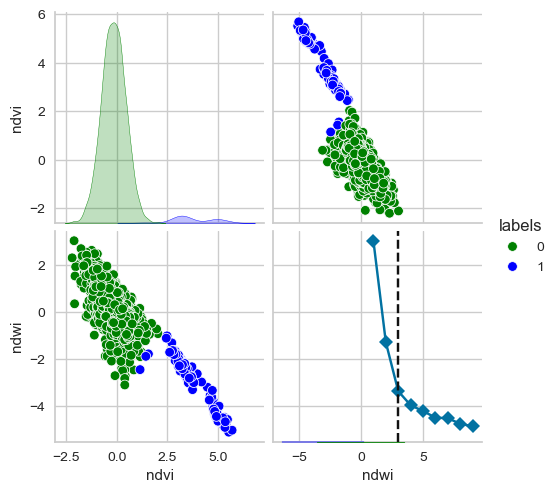

In [19]:
standarization=(df_indic-df_indic.mean(axis=0))/df_indic.std(axis=0)
km=KMeans(n_clusters=2, random_state=10)
km.fit(standarization)

d=standarization.copy()
d['labels']=km.labels_

sns.pairplot(d,hue='labels',palette={0:'green',1:'blue',2:'red',3:'black',4:'yellow'})

grp=d.groupby(km.labels_)
grp.size()
grp.mean()

## Définition du nombre de groupes

coude=KElbowVisualizer(KMeans(),k=(1,10),metric='distortion',timings=False)
coude.fit(standarization)

### Comparaison avec les données de PI

In [20]:
classe=pd.Series(km.labels_)
complete['classe']=classe

classe1=complete[complete['classe']==1]
classe0=complete[complete['classe']==0]

group1=pd.Series(len(complete))
tableau=pd.DataFrame({'brute':group1})

group2=pd.Series(len(classe1))
group2=pd.DataFrame({'step1':group2})

tableau['step1']=group2

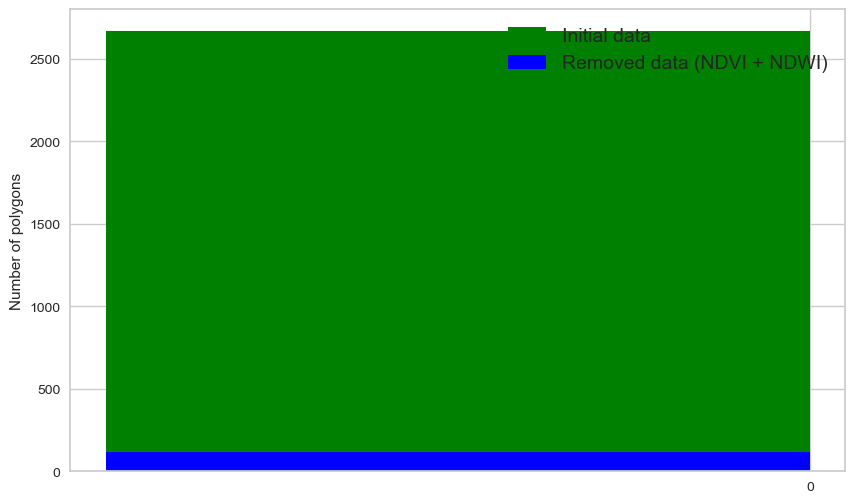

In [21]:
bar_width = 0.5
index = np.arange(len(tableau))

plt.figure(figsize=(10, 6))
plt.bar(index , tableau['brute'],bar_width, label='Initial data', color='green')
plt.bar(index, tableau['step1'], bar_width, label='Removed data (NDVI + NDWI)', color='blue')

plt.ylabel('Number of polygons')
plt.xticks(index + bar_width / 2, tableau.index)
plt.legend(fontsize=14)

plt.show()

In [22]:
surface_id_h3 = classe1['surface_id_h3']
surface_id_h3=surface_id_h3.reset_index(drop=True)

qualif_table(surface_id_h3,"invalide_niv1")

### tendance > 0

In [23]:
kmean_2 = classe0

ndb_zero=classe0[(classe0['dnbr'] == 0) & (classe0['day_nbr']==0)]

group_cuirasse=pd.Series(len(ndb_zero))
group_cuirasse=pd.DataFrame({'cuirasse':group_cuirasse})

tableau['cuirasse']=group_cuirasse
tableau['step2']=tableau['step1']+tableau['cuirasse']

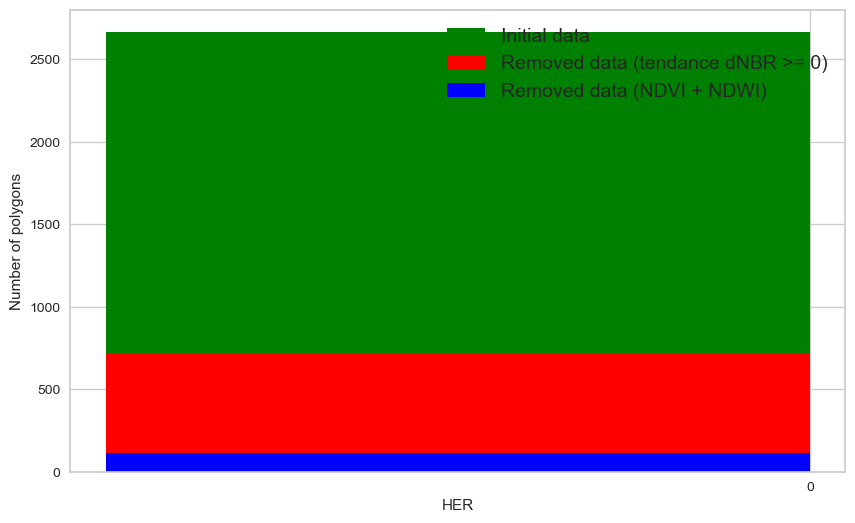

In [24]:
bar_width = 0.35
index = np.arange(len(tableau))

plt.figure(figsize=(10, 6))
plt.bar(index , tableau['brute'],bar_width, label='Initial data', color='green')
plt.bar(index, tableau['step2'], bar_width, label='Removed data (tendance dNBR >= 0)', color='red')
plt.bar(index, tableau['step1'], bar_width, label='Removed data (NDVI + NDWI)', color='blue')

plt.xlabel('HER')
plt.ylabel('Number of polygons')
plt.xticks(index + bar_width / 2, tableau.index)
plt.legend(fontsize=14)

plt.show()

In [25]:
surface_id_h3 = ndb_zero['surface_id_h3']
surface_id_h3=surface_id_h3.reset_index(drop=True)

qualif_table(surface_id_h3,'invalide_niv2')

In [26]:
kmean_2 = kmean_2[~kmean_2['surface_id_h3'].isin(ndb_zero['surface_id_h3'])]
kmean_2=kmean_2.reset_index(drop=True)

In [27]:
## create polygon group
kmean_2['ID'] = range(1, len(kmean_2)+1,1)
def find_intersecting_id(row, gdf):

    # Utiliser `sindex` pour une recherche spatiale plus efficace parmi ceux de la même date
    possible_matches_index = list(gdf.sindex.intersection(row['geometry'].bounds))
    possible_matches = gdf.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.geometry.intersects(row['geometry'])]
    
    intersecting_ids = precise_matches['ID'].tolist()
    intersecting_ids = [id_ for id_ in intersecting_ids if id_ != row['ID']]
    
    return intersecting_ids

G = nx.Graph()
for index, row in kmean_2.iterrows():
    intersecting_ids = find_intersecting_id(row, kmean_2)
    for id_ in intersecting_ids:
        G.add_edge(row['ID'], id_)

groupes = list(nx.connected_components(G))
for groupe_id, groupe in enumerate(groupes):
    for id_ in groupe:
        kmean_2.loc[kmean_2['ID'] == id_, 'groupe_id'] = groupe_id

In [28]:
dnbr_viirs=kmean_2[(kmean_2['dnbr'] >= 0.11) & (kmean_2['viirs']==1)]

group_dnbr=pd.Series(len(dnbr_viirs))
group_dnbr=pd.DataFrame({'dnbr':group_dnbr})

tableau['dnbr']=group_dnbr
tableau['step3']=tableau['step2']+tableau['dnbr']

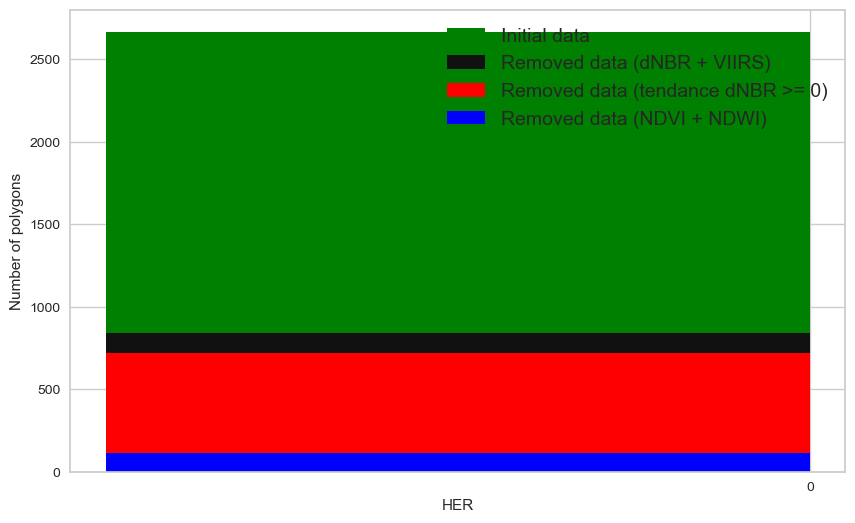

In [29]:
bar_width = 0.35
index = np.arange(len(tableau))

plt.figure(figsize=(10, 6))
plt.bar(index , tableau['brute'],bar_width, label='Initial data', color='green')
plt.bar(index, tableau['step3'], bar_width, label='Removed data (dNBR + VIIRS)', color='k')
plt.bar(index, tableau['step2'], bar_width, label='Removed data (tendance dNBR >= 0)', color='red')
plt.bar(index, tableau['step1'], bar_width, label='Removed data (NDVI + NDWI)', color='blue')

plt.xlabel('HER')
plt.ylabel('Number of polygons')
plt.xticks(index + bar_width / 2, tableau.index)
plt.legend(fontsize=14)

plt.show()

In [30]:
surface_id_h3 = dnbr_viirs['surface_id_h3']
surface_id_h3=surface_id_h3.reset_index(drop=True)

qualif_table(surface_id_h3,'validation_viirs_dnbr')

In [31]:
data_final = kmean_2[~kmean_2['surface_id_h3'].isin(dnbr_viirs['surface_id_h3'])]
data_final=data_final.reset_index(drop=True)
data_final.groupby(by='viirs').count()

,surface_id_h3,nbr,ndvi,bais2,ndwi,badi,nbr+,dnbr,stdnbr,day_nbr,...,RBR,geometry,date_,qualification,surface,surface_binned,days_viirs,classe,ID,groupe_id
viirs,,,,,,,,,,,,,,,,,,,,,
0,1828,1828,1828,1828,1828,1828,1828,1778,1828,1778,...,1778,1828,1828,0,1828,1828,0,1828,1828,1120
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,0,1,1,1,1,1,0


### Groupes

In [32]:
100-(len(data_final)/len(complete))*100

31.446776611694148